<a href="https://colab.research.google.com/github/velblu/ML-datasets/blob/master/jpx_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Task description
This is an attempt to create technical classificator based only on technical values like OHLC. No fundamental information are taken into consideration (like business sectors or financial results). 

Classificator should point to buy, sell or do nothing (long or short or no position) on next day morning (on open). Stocks will be sold on close next day. 

Target value is based on a return of next day values: (Close - Open) / Open, if:
- return <= -1%     then Short
- -1% < return < 1%  then None
- 1% <= return       then Long

There is a target data in dataset but new target data will be created.

Original data comes from: 
https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction

# B. Prerequisitions
Importing right packages..

In [1]:
# basics
import pandas
import pandas as pd
import numpy as np
# from datetime import datetime

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# drawings
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

.. and downloading dataset

In [2]:
# downloading file with data (was to big for github)
!gdown --id 10ROR3xkve2Xr0mAoOiZoa-3p490LEwZt

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=10ROR3xkve2Xr0mAoOiZoa-3p490LEwZt
To: /content/stock_prices.csv
100% 218M/218M [00:02<00:00, 85.2MB/s]


# C. Data preparation
In this part data will be loaded and analysed. Transformers will be build and tested.

## 1. Loading dataset 

In [3]:
# preparing function to load dataset
def load_dataset(folder_name: str, file_name: str, index_col: list = None) -> pandas.DataFrame:
    """
    Loading dataset. 

    :param folder_name: Folders path to file with data    
    :param file_name: Name of file 
    :param index_col: List of columns that are indexes
    :return: Dataframe with dataset
    """
    dataset = pd.read_csv(f'{file_name}', index_col=index_col)
    return dataset


In [4]:
FOLDER: str = ''
FILE: str = 'stock_prices.csv'
INDEX: list = []

# Loading dataset with prices and volumes (and other)
data = load_dataset(FOLDER, FILE, INDEX)
data.head()

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


## 2. Dataset specification
High level analysis to understand the data with little summary on the end. 
But first lets check data types..


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


Looks like most of data are numbers. Only RowId and Date are objects. 

### 2.1 SecuritiesCode 
- description: local securities code
- type: Int64
- sample value: 1301

In [6]:
# description of this data
data['SecuritiesCode'].describe().apply("{0:.1f}".format)

count    2332531.0
mean        5894.8
std         2404.2
min         1301.0
25%         3891.0
50%         6238.0
75%         7965.0
max         9997.0
Name: SecuritiesCode, dtype: object

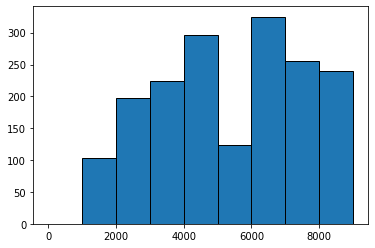

In [7]:
# securieties codes list
securieties_codes: list = list(data['SecuritiesCode'].unique())

plt.hist(securieties_codes, bins=range(0, 10000, 1000), edgecolor='black')
plt.show()

This is a column with securities id's and will be used as index.
- minimal value is 1301
- maximum value is 9997

In [8]:
# setting as index
data.set_index(keys=['SecuritiesCode'], inplace=True)
data.head()

,RowId,Date,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
SecuritiesCode,,,,,,,,,,,
1301,20170104_1301,2017-01-04,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1332,20170104_1332,2017-01-04,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1333,20170104_1333,2017-01-04,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
1376,20170104_1376,2017-01-04,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
1377,20170104_1377,2017-01-04,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


### 2.2 Date

- description: trade date
- type: date
- sample value: 2017-01-04 0:00:00


In [9]:
# describing column
pd.to_datetime(data['Date']).describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                 2332531
unique                   1202
top       2021-12-03 00:00:00
freq                     2000
first     2017-01-04 00:00:00
last      2021-12-03 00:00:00
Name: Date, dtype: object

In [10]:
# checking days of week
pd.to_datetime(data['Date']).dt.day_name().unique()

array(['Wednesday', 'Thursday', 'Friday', 'Tuesday', 'Monday'],
      dtype=object)

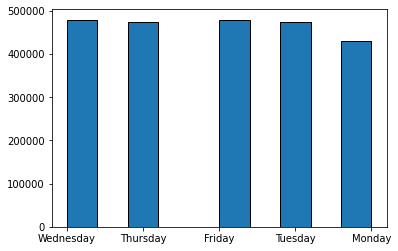

In [11]:
# days of week histogram
plt.hist(pd.to_datetime(data['Date']).dt.day_name(), 
         edgecolor='black')
plt.show()

This is column with trade dates and it will be used as index. 
- Dates starts from 2017-01-04 and finishes at 2021-12-03. 
- Dates are only monday - friday days of week 
- There is even distribution of data by days of week

In [12]:
# setting as index
data.set_index(keys=['Date'], append=True, inplace=True)
data.head()

,,RowId,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
SecuritiesCode,Date,,,,,,,,,,
1301,2017-01-04,20170104_1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1332,2017-01-04,20170104_1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
1333,2017-01-04,20170104_1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
1376,2017-01-04,20170104_1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
1377,2017-01-04,20170104_1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


### 2.3 RowID
- description: unique ID of price records
- type: string 
- sample value: 20170104_1301

In [13]:
# description of this data
data['RowId'].describe()

count           2332531
unique          2332531
top       20170104_1301
freq                  1
Name: RowId, dtype: object

In [14]:
# counting nulls 
data['RowId'].isnull().sum()

0

In [15]:
# how does structure of row id looks like? 
data['RowId'][:10]

SecuritiesCode  Date      
1301            2017-01-04    20170104_1301
1332            2017-01-04    20170104_1332
1333            2017-01-04    20170104_1333
1376            2017-01-04    20170104_1376
1377            2017-01-04    20170104_1377
1379            2017-01-04    20170104_1379
1381            2017-01-04    20170104_1381
1407            2017-01-04    20170104_1407
1414            2017-01-04    20170104_1414
1417            2017-01-04    20170104_1417
Name: RowId, dtype: object

This is column is an id for a row and brings no value for us. Will be deleted
- one row id occurs only ones
- there are no null values
- structure of this data: YYYYMMDD_SecurietiesCode

In [16]:
# adding to remove 
prepering_data_remove_columns: list = ['RowId']

### 2.4 OHLC

Open:
- description: first traded price on a day
- type: float
- sample value: 2734

High:
- description: highest traded price on a day
- type: float
- sample value: 2755

Low: 
- description: lowest traded price on a day
- type: float
- sample value: 2730

Close:
- description: last traded price on a day
- type: float
- sample value: 2742

In [17]:
# description of this data
data[['Open', 'High', 'Low', 'Close']].describe().applymap("{0:.1f}".format)

,Open,High,Low,Close
count,2324923.0,2324923.0,2324923.0,2324923.0
mean,2594.5,2626.5,2561.2,2594.0
std,3577.2,3619.4,3533.5,3576.5
min,14.0,15.0,13.0,14.0
25%,1022.0,1035.0,1009.0,1022.0
50%,1812.0,1834.0,1790.0,1811.0
75%,3030.0,3070.0,2995.0,3030.0
max,109950.0,110500.0,107200.0,109550.0


In [18]:
# securieties codes list cut to first ten securieties
securieties_codes_head: list = securieties_codes[:10]

fig = go.Figure()

# creating traces for figure - candelstick figures for selected securieties
for securities_code in securieties_codes_head:
  fig.add_trace(
      go.Candlestick(x=data.loc[securities_code].index,
                     open=data.loc[securities_code]['Open'],
                     high=data.loc[securities_code]['High'],
                     low=data.loc[securities_code]['Low'],
                     close=data.loc[securities_code]['Close'])
  )

button_all: list = [dict(label = f'All_{len(securieties_codes_head)}',
                  method = 'update',
                  args = [{'visible': [True for sec_code in securieties_codes_head],
                            'title': 'All',
                            'showlegend':False}]),]

def create_securieties_button(securieties_code: int) -> dict:
  """
  Creates single button description for securieties menu.
  
  :param X: Securieties code
  :return: Single button description
  :
  """
  return dict(label=str(securieties_code),
              method='update',
              args=[{'visible': [sec_code == securieties_code 
                                 for sec_code in securieties_codes_head],
                     'title': str(securieties_code),
                     'showlegend': False}])

# buttons list (with 'all values' button)
buttons: list  = [create_securieties_button(sec_code) 
                    for sec_code in securieties_codes_head]
all_buttons: list = button_all + buttons

# adding menu to plot
fig.update_layout(title='Selected securieties codes charts',
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons= all_buttons
)])

fig.show()

In [19]:
# checking if nulls in OHLC occurs always in all OHLC at ones

# df with rowids
ohlc_nulls = data['RowId'].to_frame()

# how many rows with null values in all OHLC at ones
ohlc_nulls['all'] = data[['Open', 'High', 'Low', 'Close']].isna().all(axis=1)

# how many rows where null values is in only one OHLC
ohlc_nulls['any'] = data[['Open', 'High', 'Low', 'Close']].isna().any(axis=1)

# for which RowIds nulls in any of OHLC do not overlap nulls witk all of OHLC
ohlc_nulls['RowId'][ohlc_nulls['any'] != ohlc_nulls['all']]
# there are non that kind of rows

Series([], Name: RowId, dtype: object)

In [20]:
# dates were all securieties do not have OHLC values 
# series of dates where all securieties count == securieties with all nulls in OHLC
ohlc_nulls_all=ohlc_nulls['RowId'].groupby(['Date']).count() == ohlc_nulls['all'].groupby(['Date']).sum()

# dates where this occured
ohlc_nulls_all[ohlc_nulls_all]

#there were only one date like that
# https://www.jpx.co.jp/english/corporate/news/news-releases/0060/20201019-01.html

Date
2020-10-01    True
dtype: bool

This columns are main information for our analysis. Rows with null should be removed.
- representing stock values in day period 
- are variety of float values 
- in time dimension creates stock chart 
- null values occur only for all OHLC values at once 
- one day (2020-10-01 ) jpx was off https://www.jpx.co.jp/english/corporate/news/news-releases/0060/20201019-01.html 

### 2.5 Volume 
- description: number of traded stocks on a day
- type: Int64
- sample value: 31400

In [21]:
# description of this data
data['Volume'].describe().apply("{0:.1f}".format)

count      2332531.0
mean        691936.6
std        3911255.9
min              0.0
25%          30300.0
50%         107100.0
75%         402100.0
max      643654000.0
Name: Volume, dtype: object

In [22]:
# how many null values
data['Volume'].isna().sum()

0

In [23]:
# when null values occur
ohlc_nulls['volume'] = data['Volume'] == 0

# checking if ohlc is null then volume != 0 ? 
ohlc_nulls['RowId'][ohlc_nulls['all'] != ohlc_nulls['volume']]

# in all row_ids (data-securieties): 
# when OHLC is null =>  volume == 0 
# or 
# when OHLC is not null => volume != 0

Series([], Name: RowId, dtype: object)

This column gives main information for our analysis as well. Rows should be removed when OHLC values are nulls.
- there is variety of values in this column
- there are no null values
- when all OHLC are null => volume == 0 
- when OHLC values are not null => volume > 0


### 2.6 AdjustmentFactor
- description: to calculate theoretical price/volume when split reverse-split happens (NOT including dividend/allotment of shares/)
- type: float
- sample value: 1

In [24]:
# how many different values?
data['AdjustmentFactor'].value_counts(dropna=False)

1.000000     2331801
0.500000         328
5.000000         113
10.000000        103
0.333333          59
2.000000          36
0.250000          33
0.200000          20
0.909091          10
0.833333           6
0.769231           6
0.666667           4
0.100000           3
0.952381           3
0.800000           2
0.142857           1
0.869565           1
4.000000           1
20.000000          1
Name: AdjustmentFactor, dtype: int64

In [25]:
# number of rows where no merge/split were done
data['AdjustmentFactor'][data['AdjustmentFactor'] == 1].count()
print('#:', data['AdjustmentFactor'][data['AdjustmentFactor'] == 1].count())
print('%:', (data['AdjustmentFactor'][data['AdjustmentFactor'] == 1].count() / 
      data['AdjustmentFactor'].count())*100)

#: 2331801
%: 99.96870352419754


In [26]:
# how many merge actions where done 
print('#:', data['AdjustmentFactor'][data['AdjustmentFactor'] > 1].count())
print('%:', (data['AdjustmentFactor'][data['AdjustmentFactor'] > 1].count() / 
      data['AdjustmentFactor'].count())*100)

#: 254
%: 0.01088945870387146


In [27]:
# how many split actions where done 
print('#:', data['AdjustmentFactor'][data['AdjustmentFactor'] < 1].count())
print('%:', (data['AdjustmentFactor'][data['AdjustmentFactor'] < 1].count() / 
      data['AdjustmentFactor'].count())*100)

#: 476
%: 0.020407017098593758


It will not influence our analysis because we are analysing only difference between Open and Close value in this same day. Will information that split/merge happen be useful? I think not.
- there are no nulls 
- there where 476 splits (0,02% of all)
- there where 254 merges (0,01% of all) 

### 2.7 SupervisionFlag 
- description: "Flag of Securities Under Supervision & Securities to Be Delisted
https://www.jpx.co.jp/english/listing/market-alerts/supervision/00-archives/index.html )"
- type: boolean
- sample value: FALSE



In [28]:
# how many null values?
data['SupervisionFlag'].isnull().sum()

0

In [29]:
# number of rows
data['SupervisionFlag'].value_counts(dropna=False, normalize=False)

False    2332001
True         530
Name: SupervisionFlag, dtype: int64

In [30]:
# percentage of rows
data['SupervisionFlag'].value_counts(dropna=False, normalize=True)

False    0.999773
True     0.000227
Name: SupervisionFlag, dtype: float64

Low number of situations where stocks where under supervisioning. This information will not be usefull.
- there are no nulls 
- there where 530 cases like that (0,02% of all) 
- need to be changed to categorical type

### 2.8 ExpectedDividend 
- description: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.
- type: float
- sample value:

In [31]:
# number of rows
data['ExpectedDividend'].value_counts(dropna=False, normalize=False)

NaN       2313666
0.00         3551
10.00         901
20.00         838
15.00         797
           ...   
18.80           1
26.22           1
325.00          1
56.60           1
16.37           1
Name: ExpectedDividend, Length: 447, dtype: int64

In [32]:
# number of cases like that
data['ExpectedDividend'].count()

18865

This columns is mostly nulls but it can be useful in this attempt. 

### 2.9 Target 
- description: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is TradeDate
- type: float
- sample value: 0.00073

New target column will have to be created. This one is inconsistent with the goals of our attempt. 

In [33]:
# adding to delete
prepering_data_remove_columns.append('Target')
prepering_data_remove_columns

['RowId', 'Target']

## 3. Transformers for data preparation
Building and testing transformers for data preparation section. 

In [34]:
# copying data for testing purposes
test_data = data.copy()

### 3.1 DeleteRowsWithNulls 

In [35]:
class DeleteRowsWithNulls(BaseEstimator, TransformerMixin):
    """
    Transformer removing rows with null values (all/any) in specified columns.

    :param subset: List of columns where null values will be searched for, if None then all columns will be used.
    :param how: Determine if row or column is removed from DataFrame, when we have at least one NA or all NA.
    """
    how: str
    subset: list

    def __init__(self, subset: list = None, how: str = 'all'):
        self.subset = subset
        self.how = how

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Set which column should be considered if None was given.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        if self.subset is None:
            self.subset = X.columns.tolist()
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Remove rows with nulls.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Transformed input (with deleted rows).
        """
        return X.dropna(subset=self.subset, how=self.how)

In [36]:
# removing rows where all OHLC values are nulls 
test_transformer = DeleteRowsWithNulls(subset=['Open', 'High', 'Low', 'Close'], how='all')
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.isna().sum()

RowId                     0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2306082
SupervisionFlag           0
Target                    0
dtype: int64

### 3.2 SortData

In [37]:
class SortData(BaseEstimator, TransformerMixin):
    """
    Transformer which sort data by columns (ascending).

    :param by: List of columns by which sorting is done
    :param axis: Axis to be sorted.
    """
    by: list
    axis: str

    def __init__(self, by: list = None, axis: str = 'index'):
        self.by = by
        self.axis = axis

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Set by which names sorting will be done if None were given in params.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        if self.by is None:
            self.by = list(X.index.names)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Sort data by names

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Sorted input.
        """
        return X.sort_values(by=self.by, axis=self.axis, ascending=True, inplace=False)

In [38]:
# sorting data by index
test_transformer = SortData(by=['SecuritiesCode', 'Date'])
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

RowId    Open    High     Low   Close  \
SecuritiesCode Date                                                        
1301           2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   
               2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   
               2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   
               2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   
               2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0   
...                                  ...     ...     ...     ...     ...   
9997           2021-11-29  20211129_9997   678.0   679.0   665.0   668.0   
               2021-11-30  20211130_9997   670.0   689.0   667.0   667.0   
               2021-12-01  20211201_9997   661.0   688.0   660.0   685.0   
               2021-12-02  20211202_9997   681.0   692.0   680.0   684.0   
               2021-12-03  20211203_9997   690.0   711.0   686.0   696.0   

                           Volume  AdjustmentFactor  ExpectedDividend  \
SecuritiesCode Date                                                     
1301           2017-01-04   31400               1.0               NaN   
               2017-01-05   17900               1.0               NaN   
               2017-01-06   19900               1.0               NaN   
               2017-01-10   24200               1.0               NaN   
               2017-01-11    9300               1.0               NaN   
...                           ...               ...               ...   
9997           2021-11-29  320800               1.0               NaN   
               2021-11-30  296300               1.0               NaN   
               2021-12-01  339100               1.0               NaN   
               2021-12-02  342900               1.0               NaN   
               2021-12-03  381100               1.0               NaN   

                           SupervisionFlag    Target  
SecuritiesCode Date                                   
1301           2017-01-04            False  0.000730  
               2017-01-05            False  0.002920  
               2017-01-06            False -0.001092  
               2017-01-10            False -0.005100  
               2017-01-11            False -0.003295  
...                                    ...       ...  
9997           2021-11-29            False  0.026987  
               2021-11-30            False -0.001460  
               2021-12-01            False  0.017544  
               2021-12-02            False  0.014368  
               2021-12-03            False  0.018414  

[2324923 rows x 10 columns]

### 3.3 AddNewClassification

In [39]:
class AddNewClassification(BaseEstimator, TransformerMixin):
    """
    Transformer which adds new target data (as column) based on next day Open and Close values.

    Target value is based on a result of next day values: (Close - Open) / Open, if:

    * result <= -1      => 1 (Short)
    * -1 < result < 1   => 0 (None)
    * 1 <= result       => 2 (Long)
    """
    new_target: pandas.Series
    new_col_name: str

    def __init__(self, new_col_name='Class'):

        self.new_col_name = new_col_name

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Calculating and categorizing new target values.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """

        def categorize_result(result) -> int:
            """
            Change numerical value to categorical value.

            :param result: Numerical value for new target
            :return: Categorical value for new target
            """
            if result <= -0.01:
                return 1
            elif -0.01 < result < 0.01:
                return 0
            else:
                return 2

        self.new_target = (X['Close'] - X['Open']) / X['Open']
        self.new_target = self.new_target.apply(categorize_result).groupby('SecuritiesCode').shift(-1).astype('category')
        self.new_target.rename('Class', inplace=True)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding column with new classificator.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with new classificator as new column.
        """
        X_out: pandas.DataFrame = X.copy()
        return X_out.join(self.new_target)

In [40]:
# creating new classification 
test_transformer = AddNewClassification()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

RowId    Open    High     Low   Close  \
SecuritiesCode Date                                                        
1301           2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   
               2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   
               2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   
               2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   
               2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0   
...                                  ...     ...     ...     ...     ...   
9997           2021-11-29  20211129_9997   678.0   679.0   665.0   668.0   
               2021-11-30  20211130_9997   670.0   689.0   667.0   667.0   
               2021-12-01  20211201_9997   661.0   688.0   660.0   685.0   
               2021-12-02  20211202_9997   681.0   692.0   680.0   684.0   
               2021-12-03  20211203_9997   690.0   711.0   686.0   696.0   

                           Volume  AdjustmentFactor  ExpectedDividend  \
SecuritiesCode Date                                                     
1301           2017-01-04   31400               1.0               NaN   
               2017-01-05   17900               1.0               NaN   
               2017-01-06   19900               1.0               NaN   
               2017-01-10   24200               1.0               NaN   
               2017-01-11    9300               1.0               NaN   
...                           ...               ...               ...   
9997           2021-11-29  320800               1.0               NaN   
               2021-11-30  296300               1.0               NaN   
               2021-12-01  339100               1.0               NaN   
               2021-12-02  342900               1.0               NaN   
               2021-12-03  381100               1.0               NaN   

                           SupervisionFlag    Target Class  
SecuritiesCode Date                                         
1301           2017-01-04            False  0.000730   0.0  
               2017-01-05            False  0.002920   0.0  
               2017-01-06            False -0.001092   0.0  
               2017-01-10            False -0.005100   0.0  
               2017-01-11            False -0.003295   0.0  
...                                    ...       ...   ...  
9997           2021-11-29            False  0.026987   0.0  
               2021-11-30            False -0.001460   2.0  
               2021-12-01            False  0.017544   0.0  
               2021-12-02            False  0.014368   0.0  
               2021-12-03            False  0.018414   NaN  

[2324923 rows x 11 columns]

### 3.4 DropColumns

In [41]:
class DropColumns(BaseEstimator, TransformerMixin):
    """
    Transformer to drop specified columns.
    """
    cols_to_drop: list

    def __init__(self, cols_to_drop: list = None):
        self.cols_to_drop = cols_to_drop

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Set columns to drop as empty list None given.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        if self.cols_to_drop is None:
            self.cols_to_drop = []
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Dropping columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with dropped columns.
        """
        return X.drop(labels=self.cols_to_drop,
                      axis=1,
                      inplace=False)

In [42]:
test_transformer = DropColumns(cols_to_drop=['RowId', 'Target'])
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 9 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Open              float64 
 1   High              float64 
 2   Low               float64 
 3   Close             float64 
 4   Volume            int64   
 5   AdjustmentFactor  float64 
 6   ExpectedDividend  float64 
 7   SupervisionFlag   bool    
 8   Class             category
dtypes: bool(1), category(1), float64(6), int64(1)
memory usage: 202.1+ MB


### 3.5 ColumnTypeChanger

In [43]:
class ColumnTypeChanger(BaseEstimator, TransformerMixin):
    """
    Transformer which change type of columns.
    """
    col: list
    to_type: str

    def __init__(self, col: str = None, to_type: str = None):
        self.col = col
        self.to_type = to_type

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Doing nothing.. 

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Changing column type.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with dropped columns.
        """
        
        if (self.to_type is None) or (self.col is None):
            return X
        else:
            X_out = X.copy()
            X_out[self.col] = X_out[self.col].astype(self.to_type)
            return X_out

In [44]:
test_transformer = ColumnTypeChanger(col='SupervisionFlag', to_type='category')
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 9 columns):
 #   Column            Dtype   
---  ------            -----   
 0   Open              float64 
 1   High              float64 
 2   Low               float64 
 3   Close             float64 
 4   Volume            int64   
 5   AdjustmentFactor  float64 
 6   ExpectedDividend  float64 
 7   SupervisionFlag   category
 8   Class             category
dtypes: category(2), float64(6), int64(1)
memory usage: 202.1+ MB


## 5. Pipeline for data preparation
Let's build a pipeline :)

In [45]:
# data preparation pipeline
data_preparation_pipeline = Pipeline(steps=[
    ('removing_null_values', DeleteRowsWithNulls(subset=['Open', 'High', 'Low', 'Close'], how='all')),
    ('sort_dataset', SortData(by=['SecuritiesCode', 'Date'])),
    ('change_supervisionflag_type', ColumnTypeChanger(col='SupervisionFlag', to_type='category')),
    ('add_new_target', AddNewClassification()),
    ('drop_columns', DropColumns(cols_to_drop=['RowId', 'Target']))
])

In [46]:
# .. and testing.. 
X_data = data_preparation_pipeline.fit_transform(X=data)
X_data.head()

Open    High     Low   Close  Volume  \
SecuritiesCode Date                                                 
1301           2017-01-04  2734.0  2755.0  2730.0  2742.0   31400   
               2017-01-05  2743.0  2747.0  2735.0  2738.0   17900   
               2017-01-06  2734.0  2744.0  2720.0  2740.0   19900   
               2017-01-10  2745.0  2754.0  2735.0  2748.0   24200   
               2017-01-11  2748.0  2752.0  2737.0  2745.0    9300   

                           AdjustmentFactor  ExpectedDividend SupervisionFlag  \
SecuritiesCode Date                                                             
1301           2017-01-04               1.0               NaN           False   
               2017-01-05               1.0               NaN           False   
               2017-01-06               1.0               NaN           False   
               2017-01-10               1.0               NaN           False   
               2017-01-11               1.0               NaN           False   

                          Class  
SecuritiesCode Date              
1301           2017-01-04   0.0  
               2017-01-05   0.0  
               2017-01-06   0.0  
               2017-01-10   0.0  
               2017-01-11   0.0

## 5. Corelations 
Checking corelations between data. 
First we have to get rid of null values on test_data. In main pipeline it will be done differently. 

In [47]:
# new dataset for corr
corr_data = X_data.copy()

In [48]:
# check nulls
corr_data.isna().sum()

Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2306082
SupervisionFlag           0
Class                  2000
dtype: int64

In [49]:
# for expected dividend column nulls will be changed to zeros 
corr_data['ExpectedDividend'] = corr_data['ExpectedDividend'].fillna(0)

In [50]:
# for class column rows with nulls will be deleted
test_transformer = DeleteRowsWithNulls(subset=['Class'], how='any')
test_transformer = test_transformer.fit(X=corr_data)
corr_data = test_transformer.transform(X=corr_data)
corr_data.isna().sum()

Open                0
High                0
Low                 0
Close               0
Volume              0
AdjustmentFactor    0
ExpectedDividend    0
SupervisionFlag     0
Class               0
dtype: int64

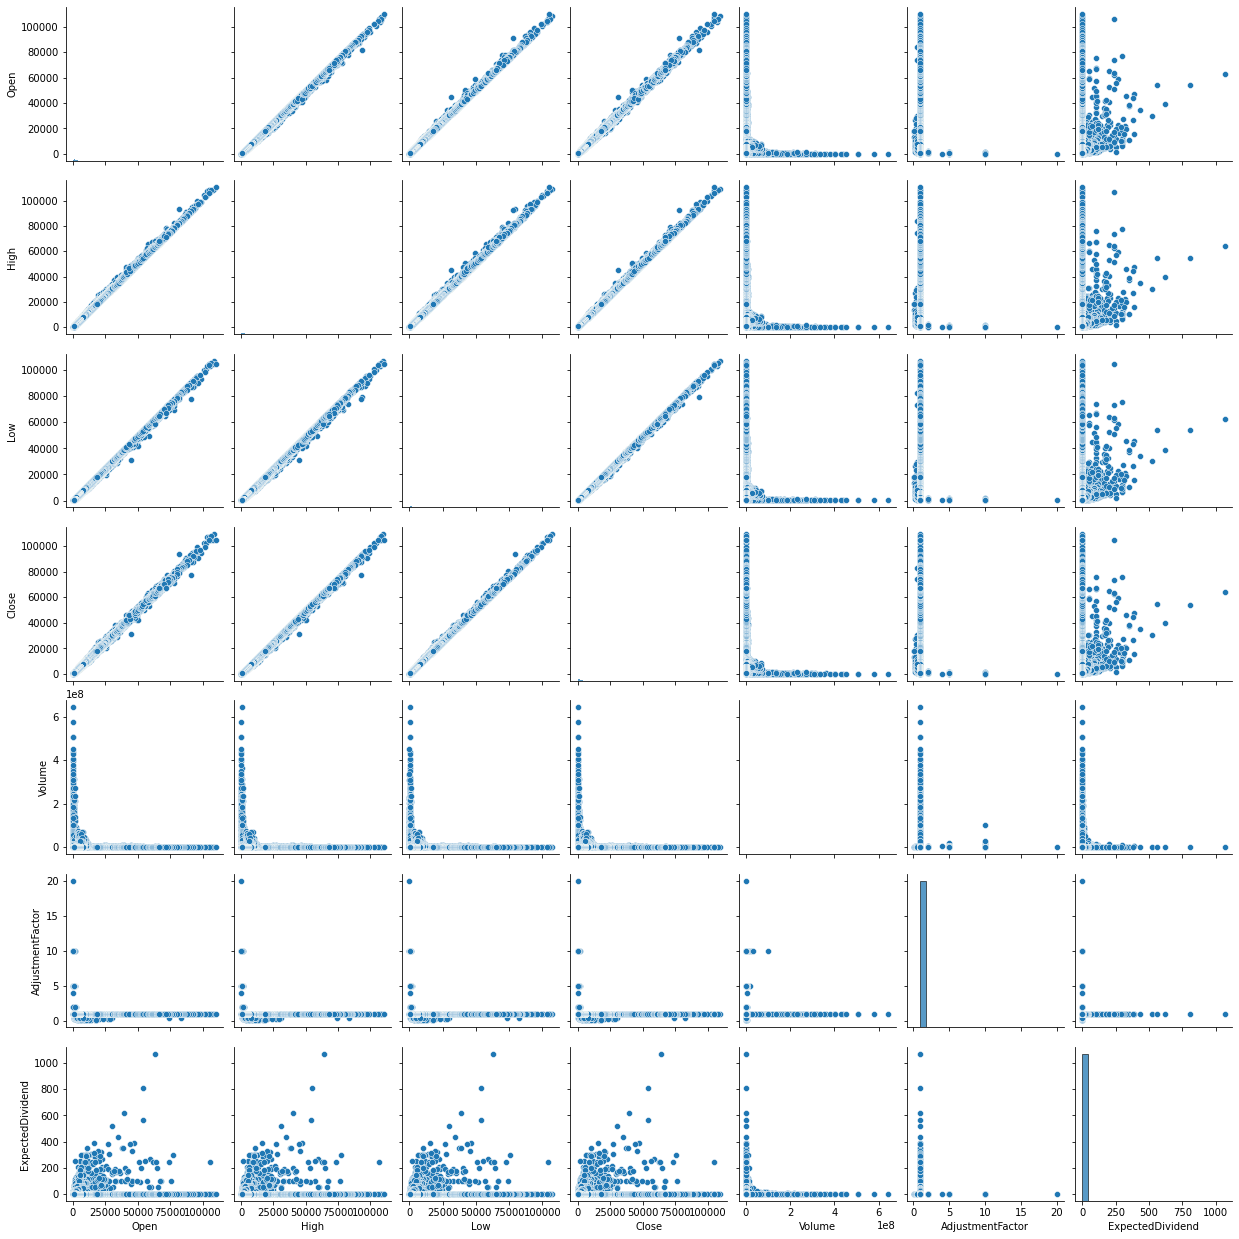

In [51]:
# Corelation as a pair of coordinates
sns.pairplot(corr_data)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



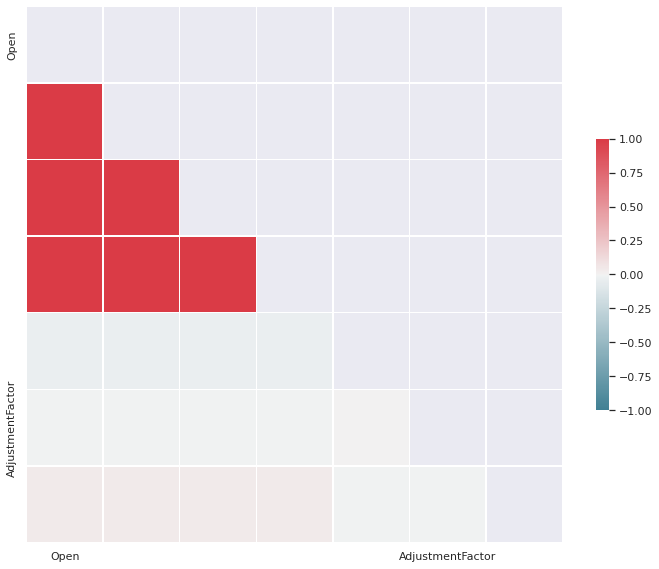

,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend
Open,1.000000,0.999851,0.999854,0.999730,-0.036540,-0.006922,0.041986
High,0.999851,1.000000,0.999755,0.999857,-0.036333,-0.006937,0.041905
Low,0.999854,0.999755,1.000000,0.999862,-0.036654,-0.006898,0.042081
Close,0.999730,0.999857,0.999862,1.000000,-0.036489,-0.006911,0.042095
Volume,-0.036540,-0.036333,-0.036654,-0.036489,1.000000,0.005308,-0.000513
AdjustmentFactor,-0.006922,-0.006937,-0.006898,-0.006911,0.005308,1.000000,-0.000401
ExpectedDividend,0.041986,0.041905,0.042081,0.042095,-0.000513,-0.000401,1.000000


In [52]:
sns.set(style="darkgrid")

corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220., 10., as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()
corr

It's not a big supprise that OHLC values are highly correlated with each other. Values are simillar. 

Rest of the dataset do not show correlation. 

# D. Feature Engineering 
Adding new features.. 

In [53]:
# but first lets prepare test dataset..
test_data = X_data.copy()

## 1. Transformers 
Creating tranformers for feature engineering pipeline.

### 1.1 AddDividendInfo



In [54]:
class AddDividendInfo(BaseEstimator, TransformerMixin):
    """
    Transformer which adds information (as column) that next day will be a dividend day.
    """
    dividend_info: pandas.Series

    def __init__(self):
        self.dividend_info = pd.Series(None, dtype='bool')

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Prepare new column with dividend as True/False column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        self.dividend_info = X['ExpectedDividend'].fillna(0).where(X['ExpectedDividend'] != 0, 1).astype('category')
        self.dividend_info.rename('ExpectedDividendInfo', inplace=True)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding new column with next day dividend as True/False column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with additional column.
        """
        X_out: pandas.DataFrame = X.copy()
        return X_out.join(self.dividend_info)

In [55]:
# adding true/false column - next day will be dividend day
test_transformer = AddDividendInfo()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data['ExpectedDividendInfo'].value_counts()

0.0       2306082
1.0          3556
10.0          900
20.0          837
15.0          797
           ...   
18.36           1
17.6            1
17.3            1
17.25           1
1070.0          1
Name: ExpectedDividendInfo, Length: 446, dtype: int64

### 1.2 AddDividendValue

In [56]:
class AddDividendValue(BaseEstimator, TransformerMixin):
    """
    Transformer which adds information (as column) about next day dividend as a percentage of Close value.
    """
    dividend_info: pandas.Series

    def __init__(self):
        self.dividend_info = pd.Series(None, dtype='float64')

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Prepare new column with dividend as a percentage of Close value.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        self.dividend_info = X['ExpectedDividend'].fillna(0) / X['Close']
        self.dividend_info.rename('ExpectedDividendAsPercentage', inplace=True)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding new column with next day dividend as a percentage of Close value.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with additional column.
        """
        X_out: pandas.DataFrame = X.copy()
        return X_out.join(self.dividend_info)

In [57]:
# adding a value of dividend as percentage of close value
test_transformer = AddDividendValue()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data['ExpectedDividendAsPercentage'].value_counts()

0.000000    2309622
0.011905         19
0.007937         18
0.010526         17
0.011111         15
             ...   
0.004139          1
0.004019          1
0.005800          1
0.005931          1
0.011098          1
Name: ExpectedDividendAsPercentage, Length: 10713, dtype: int64

### 1.3 AddSMA

In [58]:
class AddSMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from one of OHLC to Close SMA (Simple Moving Average) as Close SMA percentage.

    :param ma_size: Size of SMA
    :param ohlcv_col: OHLC choice to SMA
    :param add_ma: Add column with SMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool
    ma: pandas.Series
    percentile_ma: pandas.Series

    def __init__(self, ma_size: int = 30, ohlcv_col: str = 'Close', add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = ohlcv_col
        self.add_ma = add_ma
        self.ma = pd.Series(None, dtype='float64')
        self.percentile_ma = pd.Series(None, dtype='float64')

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Calculating values of Close SMA and len OHLC from Close SMA as Close SMA percentage.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        self.ma = X \
            .groupby('SecuritiesCode')['Close'] \
            .transform(lambda row: row.rolling(self.ma_size).mean()) \
            .rename(f'Close_SMA{self.ma_size}_Value')

        self.percentile_ma = (X[self.ohlcv_col] - self.ma) / self.ma
        self.percentile_ma.rename(f'{self.ohlcv_col}_SMA{self.ma_size}',
                                  inplace=True)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()

        if self.add_ma:
            X_out = X_out.join(self.ma)

        return X_out.join(self.percentile_ma)

In [59]:
# Adding OHLC values as percentage values to close sma 
test_transformer = AddSMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)

test_transformer = AddSMA(ma_size=10, add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)

test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 15 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   Open                          float64 
 1   High                          float64 
 2   Low                           float64 
 3   Close                         float64 
 4   Volume                        int64   
 5   AdjustmentFactor              float64 
 6   ExpectedDividend              float64 
 7   SupervisionFlag               category
 8   Class                         category
 9   ExpectedDividendInfo          category
 10  ExpectedDividendAsPercentage  float64 
 11  Close_SMA30_Value             float64 
 12  Close_SMA30                   float64 
 13  Close_SMA10_Value             float64 
 14  Close_SMA10                   float64 
dtypes: category(3), float64(11), int64(1)
memory usage: 295.2+ MB


### 1.4 AddEMA

In [60]:
class AddEMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from one of OHLC to Close EMA (Exponential Moving Average) as Close EMA percentage.

    :param ma_size: Size of EMA
    :param ohlcv_col: OHLC choice to EMA
    :param add_ma: Add column with EMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool
    ma: pandas.Series
    percentile_ma: pandas.Series

    def __init__(self, ma_size: int = 30, ohlcv_col: str = 'Close', add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = ohlcv_col
        self.add_ma = add_ma
        self.ma = pd.Series(None, dtype='float64')
        self.percentile_ma = pd.Series(None, dtype='float64')

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Calculating values of Close EMA and len OHLC from Close EMA as Close EMA percentage.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        self.ma = X \
            .groupby('SecuritiesCode')['Close'] \
            .transform(lambda row: row.ewm(self.ma_size).mean()) \
            .rename(f'Close_EMA{self.ma_size}_Value')

        self.percentile_ma = (X[self.ohlcv_col] - self.ma) / self.ma
        self.percentile_ma.rename(f'{self.ohlcv_col}_EMA{self.ma_size}',
                                  inplace=True)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()

        if self.add_ma:
            X_out = X_out.join(self.ma)

        return X_out.join(self.percentile_ma)

In [61]:
# Adding OHLC values as percentage values to close ema 

test_transformer = AddEMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 17 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   Open                          float64 
 1   High                          float64 
 2   Low                           float64 
 3   Close                         float64 
 4   Volume                        int64   
 5   AdjustmentFactor              float64 
 6   ExpectedDividend              float64 
 7   SupervisionFlag               category
 8   Class                         category
 9   ExpectedDividendInfo          category
 10  ExpectedDividendAsPercentage  float64 
 11  Close_SMA30_Value             float64 
 12  Close_SMA30                   float64 
 13  Close_SMA10_Value             float64 
 14  Close_SMA10                   float64 
 15  Close_EMA30_Value             float64 
 16  Close_EMA30                   float64 
dtypes: category(3)

### 1.5 AddVolumeSMA

In [62]:
class AddVolumeSMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from one of Volume to its SMA (Simple Moving Average) as SMA percentage.

    :param ma_size: Size of SMA
    :param add_ma: Add column with SMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool
    ma: pandas.Series
    percentile_ma: pandas.Series

    def __init__(self, ma_size: int = 30, add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = 'Volume'
        self.add_ma = add_ma
        self.ma = pd.Series(None, dtype='float64')
        self.percentile_ma = pd.Series(None, dtype='float64')

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Calculating values of SMA and len Volume from SMA as SMA percentage.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        self.ma = X \
            .groupby('SecuritiesCode')[self.ohlcv_col] \
            .transform(lambda row: row.rolling(self.ma_size).mean()) \
            .rename(f'{self.ohlcv_col}_SMA{self.ma_size}_Value')

        self.percentile_ma = (X[self.ohlcv_col] - self.ma) / self.ma
        self.percentile_ma.rename(f'{self.ohlcv_col}_SMA{self.ma_size}',
                                  inplace=True)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()

        if self.add_ma:
            X_out = X_out.join(self.ma)

        return X_out.join(self.percentile_ma)

In [63]:
test_transformer = AddVolumeSMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 19 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   Open                          float64 
 1   High                          float64 
 2   Low                           float64 
 3   Close                         float64 
 4   Volume                        int64   
 5   AdjustmentFactor              float64 
 6   ExpectedDividend              float64 
 7   SupervisionFlag               category
 8   Class                         category
 9   ExpectedDividendInfo          category
 10  ExpectedDividendAsPercentage  float64 
 11  Close_SMA30_Value             float64 
 12  Close_SMA30                   float64 
 13  Close_SMA10_Value             float64 
 14  Close_SMA10                   float64 
 15  Close_EMA30_Value             float64 
 16  Close_EMA30                   float64 
 17  Volume_SMA30_V

### 1.6 AddVolumeEMA

In [64]:
class AddVolumeEMA(BaseEstimator, TransformerMixin):
    """
    Transformer which adds length from Volume to its EMA (Exponential Moving Average) as EMA percentage.

    :param ma_size: Size of EMA
    :param add_ma: Add column with EMA value
    """
    ma_size: int
    ohlcv_col: str
    add_ma: bool
    ma: pandas.Series
    percentile_ma: pandas.Series

    def __init__(self, ma_size: int = 30,  add_ma: bool = False):
        self.ma_size = ma_size
        self.ohlcv_col = 'Volume'
        self.add_ma = add_ma
        self.ma = pd.Series(None, dtype='float64')
        self.percentile_ma = pd.Series(None, dtype='float64')

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Calculating values of EMA and len Volume from EMA as EMA percentage.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        self.ma = X \
            .groupby('SecuritiesCode')[self.ohlcv_col] \
            .transform(lambda row: row.ewm(self.ma_size).mean()) \
            .rename(f'{self.ohlcv_col}_EMA{self.ma_size}_Value')

        self.percentile_ma = (X[self.ohlcv_col] - self.ma) / self.ma
        self.percentile_ma.rename(f'{self.ohlcv_col}_EMA{self.ma_size}',
                                  inplace=True)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out: pd.DataFrame = X.copy()

        if self.add_ma:
            X_out = X_out.join(self.ma)

        return X_out.join(self.percentile_ma)

In [65]:
test_transformer = AddVolumeEMA(add_ma=True)
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

Open    High     Low   Close  Volume  \
SecuritiesCode Date                                                 
1301           2017-01-04  2734.0  2755.0  2730.0  2742.0   31400   
               2017-01-05  2743.0  2747.0  2735.0  2738.0   17900   
               2017-01-06  2734.0  2744.0  2720.0  2740.0   19900   
               2017-01-10  2745.0  2754.0  2735.0  2748.0   24200   
               2017-01-11  2748.0  2752.0  2737.0  2745.0    9300   
...                           ...     ...     ...     ...     ...   
9997           2021-11-29   678.0   679.0   665.0   668.0  320800   
               2021-11-30   670.0   689.0   667.0   667.0  296300   
               2021-12-01   661.0   688.0   660.0   685.0  339100   
               2021-12-02   681.0   692.0   680.0   684.0  342900   
               2021-12-03   690.0   711.0   686.0   696.0  381100   

                           AdjustmentFactor  ExpectedDividend SupervisionFlag  \
SecuritiesCode Date                                                             
1301           2017-01-04               1.0               NaN           False   
               2017-01-05               1.0               NaN           False   
               2017-01-06               1.0               NaN           False   
               2017-01-10               1.0               NaN           False   
               2017-01-11               1.0               NaN           False   
...                                     ...               ...             ...   
9997           2021-11-29               1.0               NaN           False   
               2021-11-30               1.0               NaN           False   
               2021-12-01               1.0               NaN           False   
               2021-12-02               1.0               NaN           False   
               2021-12-03               1.0               NaN           False   

                          Class ExpectedDividendInfo  ...  Close_SMA30_Value  \
SecuritiesCode Date                                   ...                      
1301           2017-01-04   0.0                  0.0  ...                NaN   
               2017-01-05   0.0                  0.0  ...                NaN   
               2017-01-06   0.0                  0.0  ...                NaN   
               2017-01-10   0.0                  0.0  ...                NaN   
               2017-01-11   0.0                  0.0  ...                NaN   
...                         ...                  ...  ...                ...   
9997           2021-11-29   0.0                  0.0  ...         764.766667   
               2021-11-30   2.0                  0.0  ...         759.233333   
               2021-12-01   0.0                  0.0  ...         754.266667   
               2021-12-02   0.0                  0.0  ...         749.433333   
               2021-12-03   NaN                  0.0  ...         745.333333   

                           Close_SMA30  Close_SMA10_Value  Close_SMA10  \
SecuritiesCode Date                                                      
1301           2017-01-04          NaN                NaN          NaN   
               2017-01-05          NaN                NaN          NaN   
               2017-01-06          NaN                NaN          NaN   
               2017-01-10          NaN                NaN          NaN   
               2017-01-11          NaN                NaN          NaN   
...                                ...                ...          ...   
9997           2021-11-29    -0.126531              712.1    -0.061930   
               2021-11-30    -0.121482              704.1    -0.052691   
               2021-12-01    -0.091833              699.5    -0.020729   
               2021-12-02    -0.087310              694.5    -0.015119   
               2021-12-03    -0.066190              692.5     0.005054   

                           Close_EMA30_Value  Close_EMA30  Volume_SMA30_V

### 1.7 AddSmaEmaRelation

In [66]:
class AddSmaEmaRelation(BaseEstimator, TransformerMixin):
    """
    Transformer which adds relation between SMA and EMA of given size.

    Transformer dodający zależność pomiędzy średnimi SMA i EWM
    dla tych samych rozmiarów średniej i tego samego OHLCV
    Exponential Moving Average

    :param ma_size: Size of SMA and EMA
    :param ohlcv_col: Choice from OHLCV value
    """
    ohlcv_col: str
    ma_size: int
    relation: pandas.Series

    def __init__(self, ma_size: int = 30, ohlcv_col: str = 'Close'):
        self.ohlcv_col = ohlcv_col
        self.ma_size = ma_size
        self.relation = pd.Series(None, dtype='float64')

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Calculating SMA to EMA relation as EMA percentage for given MA size.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        ema = X \
            .groupby('SecuritiesCode')[self.ohlcv_col] \
            .transform(lambda row: row.ewm(self.ma_size).mean()) \
            .rename('ema')

        sma = X \
            .groupby('SecuritiesCode')[self.ohlcv_col] \
            .transform(lambda row: row.rolling(self.ma_size).mean()) \
            .rename('sma')

        self.relation = (ema - sma) / ema
        self.relation.rename(f'{self.ohlcv_col}_SMA{self.ma_size}vsEWM{self.ma_size}',
                             inplace=True)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        X_out: pd.DataFrame = X.copy()
        return X_out.join(self.relation)

In [67]:
# comparing SMA to EMA for this same MA sizes
test_transformer = AddSmaEmaRelation()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data[['Close_SMA30_Value', 'Close_EMA30_Value', 'Close_SMA30vsEWM30']]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 22 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   Open                          float64 
 1   High                          float64 
 2   Low                           float64 
 3   Close                         float64 
 4   Volume                        int64   
 5   AdjustmentFactor              float64 
 6   ExpectedDividend              float64 
 7   SupervisionFlag               category
 8   Class                         category
 9   ExpectedDividendInfo          category
 10  ExpectedDividendAsPercentage  float64 
 11  Close_SMA30_Value             float64 
 12  Close_SMA30                   float64 
 13  Close_SMA10_Value             float64 
 14  Close_SMA10                   float64 
 15  Close_EMA30_Value             float64 
 16  Close_EMA30                   float64 
 17  Volume_SMA30_V

### 1.8 AddShortLongMaRelation

In [68]:
class AddShortLongMaRelation(BaseEstimator, TransformerMixin):
    """
    Transformer which adds relation between long and short MA of given type and sizes.

    :param short_ma_size: Size of short MA
    :param long_ma_size: Size of long MA
    :param ma_type: Type of MA (SMA or EMA)
    :param ohlcv_col: Choice from OHLCV value
    """
    short_ma_size: int
    long_ma_size: int
    ma_type: str
    ohlcv_col: str
    relation: pandas.Series

    def __init__(self, short_ma_size: int = 10, long_ma_size: int = 30, ma_type: str = 'sma', ohlcv_col: str = 'Close'):
        self.short_ma_size = short_ma_size
        self.long_ma_size = long_ma_size
        self.ma_type = ma_type
        self.ohlcv_col = ohlcv_col
        self.relation = pd.Series(None, dtype='float64')

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Calculating long MA to short MA relation as percentage of long MA.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        if self.ma_type == 'sma':
            long_ma_lambda = lambda row: row.rolling(self.long_ma_size).mean()
            short_ma_lambda = lambda row: row.rolling(self.short_ma_size).mean()
        elif self.ma_type == 'ema':
            long_ma_lambda = lambda row: row.ewm(self.long_ma_size).mean()
            short_ma_lambda = lambda row: row.ewm(self.short_ma_size).mean()
        else:
            long_ma_lambda = short_ma_lambda = None

        long_ma = X \
            .groupby('SecuritiesCode')[self.ohlcv_col] \
            .transform(long_ma_lambda) \
            .rename('long_ma')

        short_ma = X \
            .groupby('SecuritiesCode')[self.ohlcv_col] \
            .transform(short_ma_lambda) \
            .rename('short_ma')

        relation_col_name: str = f'{self.ohlcv_col}_{self.ma_type.upper() + str(self.short_ma_size)}' + \
                                 f'vs{self.ma_type.upper() + str(self.long_ma_size)}'

        self.relation = (long_ma - short_ma) / long_ma
        self.relation.rename(relation_col_name, inplace=True)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding column.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        X_out: pd.DataFrame = X.copy()
        return X_out.join(self.relation)

In [69]:
# Comparing short and long MA (SMA or EMA)

test_transformer = AddShortLongMaRelation()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data[['Close_SMA10_Value', 'Close_SMA30_Value', 'Close_SMA10vsSMA30']]
test_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2324923 entries, (1301, '2017-01-04') to (9997, '2021-12-03')
Data columns (total 23 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   Open                          float64 
 1   High                          float64 
 2   Low                           float64 
 3   Close                         float64 
 4   Volume                        int64   
 5   AdjustmentFactor              float64 
 6   ExpectedDividend              float64 
 7   SupervisionFlag               category
 8   Class                         category
 9   ExpectedDividendInfo          category
 10  ExpectedDividendAsPercentage  float64 
 11  Close_SMA30_Value             float64 
 12  Close_SMA30                   float64 
 13  Close_SMA10_Value             float64 
 14  Close_SMA10                   float64 
 15  Close_EMA30_Value             float64 
 16  Close_EMA30                   float64 
 17  Volume_SMA30_V

### 1.9 ResetIndex

In [70]:
class ResetIndex(BaseEstimator, TransformerMixin):
    """
    Reset (drop) dataframe index.
    """

    def __init__(self):
        pass

    def fit(self, X=None, y=None):
        """
        Doing nothing.

        :param X: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Droping index of dataframe

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        X_out: pd.DataFrame = X.copy()
        return X_out.reset_index(drop=True)

In [71]:
# removing index
test_transformer = ResetIndex()
test_transformer = test_transformer.fit(X=test_data)
test_data = test_transformer.transform(X=test_data)
test_data

,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Class,ExpectedDividendInfo,...,Close_SMA10_Value,Close_SMA10,Close_EMA30_Value,Close_EMA30,Volume_SMA30_Value,Volume_SMA30,Volume_EMA30_Value,Volume_EMA30,Close_SMA30vsEWM30,Close_SMA10vsSMA30
0,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.0,0.0,...,NaN,NaN,2742.000000,0.000000,NaN,NaN,31400.000000,0.000000,NaN,NaN
1,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.0,0.0,...,NaN,NaN,2739.967213,-0.000718,NaN,NaN,24539.344262,-0.270559,NaN,NaN
2,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,0.0,0.0,...,NaN,NaN,2739.978502,0.000008,NaN,NaN,22941.920459,-0.132592,NaN,NaN
3,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,0.0,0.0,...,NaN,NaN,2742.083562,0.002158,NaN,NaN,23272.074770,0.039873,NaN,NaN
4,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,0.0,0.0,...,NaN,NaN,2742.705714,0.000837,NaN,NaN,20291.466225,-0.541679,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324918,678.0,679.0,665.0,668.0,320800,1.0,NaN,False,0.0,0.0,...,712.1,-0.061930,797.799623,-0.162697,238233.333333,0.346579,270363.742816,0.186550,0.041405,0.068866
2324919,670.0,689.0,667.0,667.0,296300,1.0,NaN,False,2.0,0.0,...,704.1,-0.052691,793.580280,-0.159505,244930.000000,0.209733,271200.396274,0.092550,0.043281,0.072617
2324920,661.0,688.0,660.0,685.0,339100,1.0,NaN,False,0.0,0.0,...,699.5,-0.020729,790.077690,-0.132997,250670.000000,0.352775,273390.706071,0.240349,0.045326,0.072609
2324921,681.0,692.0,680.0,684.0,342900,1.0,NaN,False,0.0,0.0,...,694.5,-0.015119,786.655829,-0.130496,255733.333333,0.340850,275632.941359,0.244046,0.047317,0.073300


## 2. Pipeline for feature engineering
Let's build a pipeline :) 

In [72]:
# feature engineering pipeline
feature_engineering_pipeline = Pipeline(steps=[
    # sma10 for all OHLC
    ('add_sma10_open', AddSMA(ma_size=10, ohlcv_col='Open', add_ma=False)),
    ('add_sma10_high', AddSMA(ma_size=10, ohlcv_col='High', add_ma=False)),
    ('add_sma10_low', AddSMA(ma_size=10, ohlcv_col='Low', add_ma=False)),
    ('add_sma10_close', AddSMA(ma_size=10, ohlcv_col='Close', add_ma=False)),

    # sma30 for all OHLC
    ('add_sma30_open', AddSMA(ma_size=30, ohlcv_col='Open', add_ma=False)),
    ('add_sma30_high', AddSMA(ma_size=30, ohlcv_col='High', add_ma=False)),
    ('add_sma30_low', AddSMA(ma_size=30, ohlcv_col='Low', add_ma=False)),
    ('add_sma30_close', AddSMA(ma_size=30, ohlcv_col='Close', add_ma=False)),
    
    # ema10 for all OHLCV
    ('add_ema10_open', AddEMA(ma_size=10, ohlcv_col='Open', add_ma=False)),
    ('add_ema10_high', AddEMA(ma_size=10, ohlcv_col='High', add_ma=False)),
    ('add_ema10_low', AddEMA(ma_size=10, ohlcv_col='Low', add_ma=False)),
    ('add_ema10_close', AddEMA(ma_size=10, ohlcv_col='Close', add_ma=False)),

    # ema30 for all OHLCV
    ('add_ema30_open', AddEMA(ma_size=30, ohlcv_col='Open', add_ma=False)),
    ('add_ema30_high', AddEMA(ma_size=30, ohlcv_col='High', add_ma=False)),
    ('add_ema30_low', AddEMA(ma_size=30, ohlcv_col='Low', add_ma=False)),
    ('add_ema30_close', AddEMA(ma_size=30, ohlcv_col='Close', add_ma=False)),

    # SMA & EMA for Volume
    ('add_sma10_volume', AddVolumeSMA(ma_size=10, add_ma=False)),
    ('add_sma30_volume', AddVolumeSMA(ma_size=30, add_ma=False)),
    ('add_ema10_volume', AddVolumeEMA(ma_size=10, add_ma=False)),
    ('add_ema30_volume', AddVolumeEMA(ma_size=30, add_ma=False)),

    # sma10 vs ema10 for all OHLCV
    ('add_sma_ema_10_relation_open', AddSmaEmaRelation(ma_size=10, ohlcv_col='Open')),
    ('add_sma_ema_10_relation_high', AddSmaEmaRelation(ma_size=10, ohlcv_col='High')),
    ('add_sma_ema_10_relation_low', AddSmaEmaRelation(ma_size=10, ohlcv_col='Low')),
    ('add_sma_ema_10_relation_close', AddSmaEmaRelation(ma_size=10, ohlcv_col='Close')),
    ('add_sma_ema_10_relation_volume', AddSmaEmaRelation(ma_size=10, ohlcv_col='Volume')),

    # sma30 vs ema30 for all OHLCV
    ('add_sma_ema_30_relation_open', AddSmaEmaRelation(ma_size=30, ohlcv_col='Open')),
    ('add_sma_ema_30_relation_high', AddSmaEmaRelation(ma_size=30, ohlcv_col='High')),
    ('add_sma_ema_30_relation_low', AddSmaEmaRelation(ma_size=30, ohlcv_col='Low')),
    ('add_sma_ema_30_relation_close', AddSmaEmaRelation(ma_size=30, ohlcv_col='Close')),
    ('add_sma_ema_30_relation_volume', AddSmaEmaRelation(ma_size=30, ohlcv_col='Volume')),

    # sma10 vs sma30 for all OHLCV
    ('add_sma10_sma30_relation_open', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='sma', ohlcv_col='Open')),
    ('add_sma10_sma30_relation_high', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='sma', ohlcv_col='High')),
    ('add_sma10_sma30_relation_low', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                            ma_type='sma', ohlcv_col='Low')),
    ('add_sma10_sma30_relation_close', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                              ma_type='sma', ohlcv_col='Close')),
    ('add_sma10_sma30_relation_volume', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                               ma_type='sma', ohlcv_col='Volume')),

    # ema10 vs ema30 for all OHLCV
    ('add_ema10_ema30_relation_open', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='ema', ohlcv_col='Open')),
    ('add_ema10_ema30_relation_high', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                             ma_type='ema', ohlcv_col='High')),
    ('add_ema10_ema30_relation_low', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                            ma_type='ema', ohlcv_col='Low')),
    ('add_ema10_ema30_relation_close', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                              ma_type='ema', ohlcv_col='Close')),
    ('add_ema10_ema30_relation_volume', AddShortLongMaRelation(short_ma_size=10, long_ma_size=30,
                                                               ma_type='ema', ohlcv_col='Volume')),
    # other
    ('add_dividend_information', AddDividendInfo()),
    ('add_dividend_value', AddDividendValue()),

    # cleanup
    ('drop_columns', DropColumns(cols_to_drop=['Open', 'High', 'Low', 'Close', 'Volume', 'ExpectedDividend'])),
    ('drop_nulls', DeleteRowsWithNulls(how='any')),
    ('drop_index', ResetIndex())
])

In [73]:
X_data = feature_engineering_pipeline.fit_transform(X=X_data)

## 3. Correlation
Checking corelation of new features

In [74]:
# new dataset for corr
corr_data = X_data.copy()

In [75]:
# check nulls
corr_data.isna().sum()

AdjustmentFactor                0
SupervisionFlag                 0
Class                           0
Open_SMA10                      0
High_SMA10                      0
Low_SMA10                       0
Close_SMA10                     0
Open_SMA30                      0
High_SMA30                      0
Low_SMA30                       0
Close_SMA30                     0
Open_EMA10                      0
High_EMA10                      0
Low_EMA10                       0
Close_EMA10                     0
Open_EMA30                      0
High_EMA30                      0
Low_EMA30                       0
Close_EMA30                     0
Volume_SMA10                    0
Volume_SMA30                    0
Volume_EMA10                    0
Volume_EMA30                    0
Open_SMA10vsEWM10               0
High_SMA10vsEWM10               0
Low_SMA10vsEWM10                0
Close_SMA10vsEWM10              0
Volume_SMA10vsEWM10             0
Open_SMA30vsEWM30               0
High_SMA30vsEW

In [76]:
corr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264923 entries, 0 to 2264922
Data columns (total 45 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   AdjustmentFactor              float64 
 1   SupervisionFlag               category
 2   Class                         category
 3   Open_SMA10                    float64 
 4   High_SMA10                    float64 
 5   Low_SMA10                     float64 
 6   Close_SMA10                   float64 
 7   Open_SMA30                    float64 
 8   High_SMA30                    float64 
 9   Low_SMA30                     float64 
 10  Close_SMA30                   float64 
 11  Open_EMA10                    float64 
 12  High_EMA10                    float64 
 13  Low_EMA10                     float64 
 14  Close_EMA10                   float64 
 15  Open_EMA30                    float64 
 16  High_EMA30                    float64 
 17  Low_EMA30                     float64 
 18  Cl

In [ ]:
# Corelation as a pair of coordinates
sns.pairplot(corr_data)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



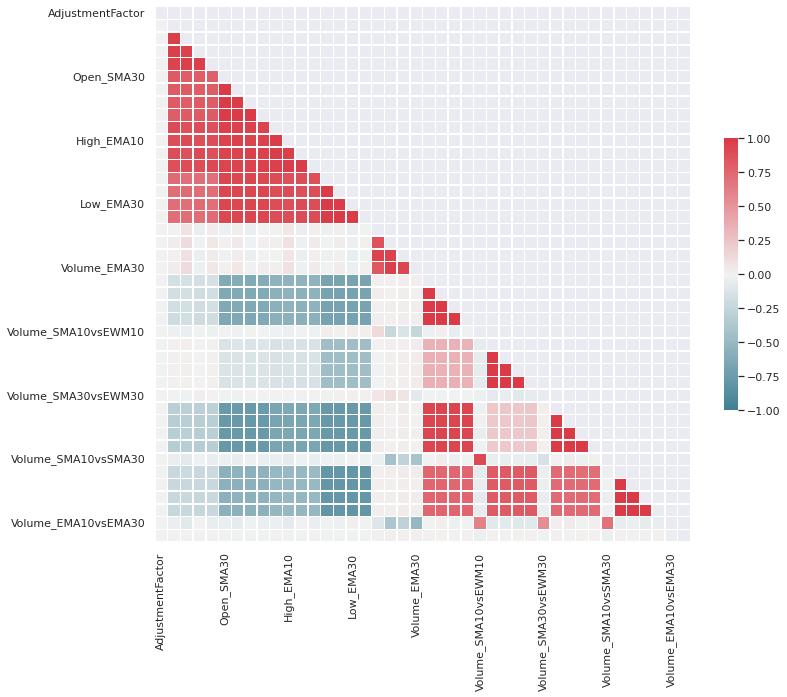

,AdjustmentFactor,Open_SMA10,High_SMA10,Low_SMA10,Close_SMA10,Open_SMA30,High_SMA30,Low_SMA30,Close_SMA30,Open_EMA10,...,High_SMA10vsSMA30,Low_SMA10vsSMA30,Close_SMA10vsSMA30,Volume_SMA10vsSMA30,Open_EMA10vsEMA30,High_EMA10vsEMA30,Low_EMA10vsEMA30,Close_EMA10vsEMA30,Volume_EMA10vsEMA30,ExpectedDividendAsPercentage
AdjustmentFactor,1.000000,0.001308,0.001358,0.001981,0.002060,0.001394,0.001419,0.001729,0.001773,0.001638,...,-0.001433,-0.001289,-0.001430,-0.004510,-0.000852,-0.000915,-0.000872,-0.000936,-0.003006,-0.000532
Open_SMA10,0.001308,1.000000,0.969934,0.973661,0.951967,0.826012,0.816749,0.815412,0.809773,0.911084,...,-0.317965,-0.314948,-0.325855,-0.038086,-0.219668,-0.226112,-0.223409,-0.230318,-0.034500,0.007245
High_SMA10,0.001358,0.969934,1.000000,0.954920,0.975862,0.804997,0.826088,0.799943,0.815989,0.882663,...,-0.312146,-0.304484,-0.318697,-0.073107,-0.209143,-0.219658,-0.212629,-0.222582,-0.081854,0.005811
Low_SMA10,0.001981,0.973661,0.954920,1.000000,0.973781,0.809956,0.806183,0.825811,0.818056,0.890661,...,-0.314818,-0.315957,-0.325377,-0.008026,-0.219837,-0.225968,-0.227055,-0.232739,0.004845,0.005636
Close_SMA10,0.002060,0.951967,0.975862,0.973781,1.000000,0.794024,0.811742,0.807534,0.826330,0.869146,...,-0.309532,-0.306187,-0.319650,-0.041080,-0.209604,-0.218818,-0.215641,-0.225064,-0.040498,0.007662
Open_SMA30,0.001394,0.826012,0.804997,0.809956,0.794024,1.000000,0.992211,0.993258,0.987530,0.965933,...,-0.770100,-0.767446,-0.774489,-0.031218,-0.557102,-0.562835,-0.560063,-0.566666,-0.033145,-0.002127
High_SMA30,0.001419,0.816749,0.826088,0.806183,0.811742,0.992211,1.000000,0.988182,0.993583,0.955953,...,-0.766293,-0.761261,-0.770069,-0.049690,-0.551042,-0.558895,-0.553912,-0.562112,-0.057868,-0.002845
Low_SMA30,0.001729,0.815412,0.799943,0.825811,0.807534,0.993258,0.988182,1.000000,0.993166,0.957156,...,-0.767727,-0.767148,-0.773482,-0.015846,-0.556561,-0.562151,-0.561276,-0.567277,-0.013071,-0.002686
Close_SMA30,0.001773,0.809773,0.815989,0.818056,0.826330,0.987530,0.993583,0.993166,1.000000,0.950076,...,-0.763797,-0.760964,-0.769418,-0.033107,-0.550380,-0.557583,-0.554562,-0.562502,-0.036477,-0.001795
Open_EMA10,0.001638,0.911084,0.882663,0.890661,0.869146,0.965933,0.955953,0.957156,0.950076,1.000000,...,-0.665025,-0.662753,-0.671651,-0.037082,-0.503743,-0.509966,-0.507836,-0.514842,-0.031229,0.000486


In [77]:
sns.set(style="darkgrid")

corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220., 10., as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()
corr

# E. Preproccessing and modeling 

## 1. Preprocessing




In [160]:
# firstly lets prepare test dataset..
test_data = X_data.copy()

In [161]:
# and split it for X and y
y_test_data = test_data.pop(item='Class')


### 1.1 Stadarizing data..
But only numerical .. 

In [162]:
sf_series = test_data.pop(item='SupervisionFlag')
ed_series = test_data.pop(item='ExpectedDividendInfo')

In [163]:
# write down column names
test_data_cols = test_data.columns
test_data_cols

Index(['AdjustmentFactor', 'Open_SMA10', 'High_SMA10', 'Low_SMA10',
       'Close_SMA10', 'Open_SMA30', 'High_SMA30', 'Low_SMA30', 'Close_SMA30',
       'Open_EMA10', 'High_EMA10', 'Low_EMA10', 'Close_EMA10', 'Open_EMA30',
       'High_EMA30', 'Low_EMA30', 'Close_EMA30', 'Volume_SMA10',
       'Volume_SMA30', 'Volume_EMA10', 'Volume_EMA30', 'Open_SMA10vsEWM10',
       'High_SMA10vsEWM10', 'Low_SMA10vsEWM10', 'Close_SMA10vsEWM10',
       'Volume_SMA10vsEWM10', 'Open_SMA30vsEWM30', 'High_SMA30vsEWM30',
       'Low_SMA30vsEWM30', 'Close_SMA30vsEWM30', 'Volume_SMA30vsEWM30',
       'Open_SMA10vsSMA30', 'High_SMA10vsSMA30', 'Low_SMA10vsSMA30',
       'Close_SMA10vsSMA30', 'Volume_SMA10vsSMA30', 'Open_EMA10vsEMA30',
       'High_EMA10vsEMA30', 'Low_EMA10vsEMA30', 'Close_EMA10vsEMA30',
       'Volume_EMA10vsEMA30', 'ExpectedDividendAsPercentage'],
      dtype='object')

In [164]:
# scaling
test_transformer = StandardScaler()
test_data = test_transformer.fit_transform(X=test_data)
test_data

array([[-0.00758225,  0.37233283,  0.19534678, ..., -0.02561132,
        -0.71648735, -0.0701454 ],
       [-0.00758225,  0.3673899 ,  0.2247572 , ..., -0.04195149,
        -0.71888542, -0.0701454 ],
       [-0.00758225,  0.27961182,  0.11714616, ..., -0.05605959,
        -0.70767978, -0.0701454 ],
       ...,
       [-0.00758225, -0.81958112, -0.56138995, ...,  1.24256916,
         0.19798145, -0.0701454 ],
       [-0.00758225, -0.92788497, -0.48235305, ...,  1.26130454,
         0.08804374, -0.0701454 ],
       [-0.00758225, -0.34445475, -0.27959993, ...,  1.27598811,
        -0.01232041, -0.0701454 ]])

In [165]:
# but I have to cast it on DataFrame .. and column names are gone :/
test_data = pd.DataFrame(test_data, columns=test_data_cols)
test_data = test_data.join(sf_series)
test_data = test_data.join(ed_series)
test_data.head()
# I think I will build my own scaler ..

,AdjustmentFactor,Open_SMA10,High_SMA10,Low_SMA10,Close_SMA10,Open_SMA30,High_SMA30,Low_SMA30,Close_SMA30,Open_EMA10,...,Close_SMA10vsSMA30,Volume_SMA10vsSMA30,Open_EMA10vsEMA30,High_EMA10vsEMA30,Low_EMA10vsEMA30,Close_EMA10vsEMA30,Volume_EMA10vsEMA30,ExpectedDividendAsPercentage,SupervisionFlag,ExpectedDividendInfo
0,-0.007582,0.372333,0.195347,0.512240,0.387276,0.206646,0.119988,0.278108,0.218078,0.312734,...,-0.059438,-0.669901,-0.012029,-0.023043,-0.020507,-0.025611,-0.716487,-0.070145,False,0.0
1,-0.007582,0.367390,0.224757,0.561256,0.336406,0.224799,0.155057,0.323513,0.212643,0.320066,...,-0.096129,-0.865720,-0.031489,-0.041646,-0.040337,-0.041951,-0.718885,-0.070145,False,0.0
2,-0.007582,0.279612,0.117146,0.413565,0.280049,0.204058,0.123191,0.272572,0.206717,0.268659,...,-0.137218,-0.970965,-0.047048,-0.055415,-0.053627,-0.056060,-0.707680,-0.070145,False,0.0
3,-0.007582,0.280583,0.168886,0.456352,0.349388,0.231119,0.175562,0.320988,0.268575,0.289794,...,-0.184782,-1.142385,-0.063566,-0.072649,-0.069966,-0.074364,-0.782933,-0.070145,False,0.0
4,-0.007582,0.278346,0.239496,0.477873,0.437560,0.261650,0.242743,0.363919,0.345418,0.310034,...,-0.241437,-1.325438,-0.081403,-0.094400,-0.088664,-0.097819,-0.843145,-0.070145,False,0.0


### 1.2  Principal Component Analysis
Performing PCA to compute principal components and change basis of data. 


In [166]:
# PCA
pca = PCA(n_components=None )
pca.fit(test_data)

# Variance ratio.. 
pca.explained_variance_ratio_

array([3.95319749e-01, 2.22548898e-01, 1.27279381e-01, 7.82542175e-02,
       6.57660546e-02, 4.14337686e-02, 2.44264968e-02, 1.87242012e-02,
       9.77195836e-03, 6.38488777e-03, 2.85585878e-03, 1.88783159e-03,
       1.43931135e-03, 1.29768498e-03, 1.23317761e-03, 3.16424868e-04,
       2.64053751e-04, 1.57476634e-04, 1.28335720e-04, 1.20739010e-04,
       1.06391451e-04, 9.31078641e-05, 7.34885038e-05, 2.98961988e-05,
       2.80974365e-05, 1.82643671e-05, 1.03493142e-05, 6.17613564e-06,
       5.49983619e-06, 4.37040020e-06, 4.27248186e-06, 4.13557752e-06,
       2.47245272e-06, 1.15475073e-06, 5.62441163e-07, 3.79318519e-07,
       3.30906025e-07, 1.73564487e-07, 1.48473894e-07, 1.04442932e-07,
       4.71659580e-08, 4.44519450e-08, 1.77165266e-08, 7.85595873e-09])

In [167]:
# .. and cumulative..
np.cumsum(pca.explained_variance_ratio_)

array([0.39531975, 0.61786865, 0.74514803, 0.82340225, 0.8891683 ,
       0.93060207, 0.95502857, 0.97375277, 0.98352472, 0.98990961,
       0.99276547, 0.9946533 , 0.99609261, 0.9973903 , 0.99862348,
       0.9989399 , 0.99920396, 0.99936143, 0.99948977, 0.99961051,
       0.9997169 , 0.99981001, 0.99988349, 0.99991339, 0.99994149,
       0.99995975, 0.9999701 , 0.99997628, 0.99998178, 0.99998615,
       0.99999042, 0.99999456, 0.99999703, 0.99999818, 0.99999875,
       0.99999913, 0.99999946, 0.99999963, 0.99999978, 0.99999988,
       0.99999993, 0.99999997, 0.99999999, 1.        ])

<BarContainer object of 44 artists>

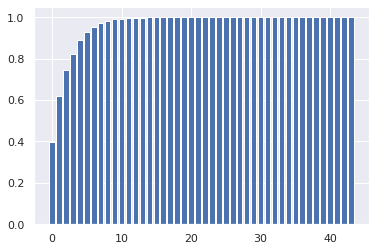

In [168]:
plt.bar(range(44), np.cumsum(pca.explained_variance_ratio_))

First five components describie 89% of the data. Should be enough.


What are they telling us about the data set? 

<BarContainer object of 44 artists>

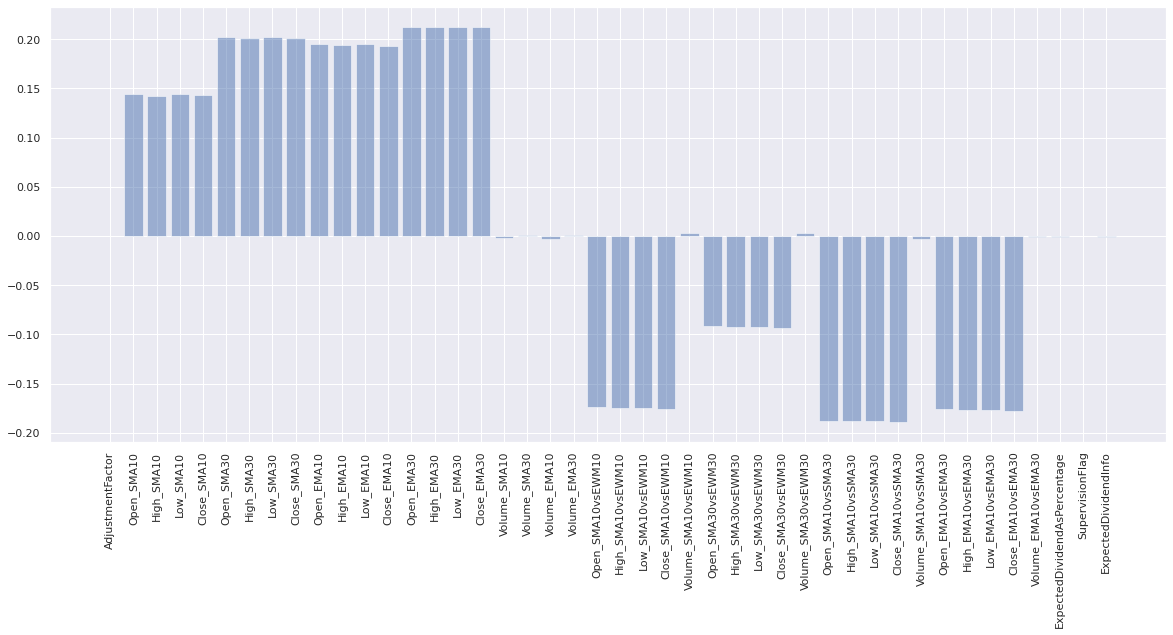

In [169]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(test_data.columns, pca.components_[0, :], label='Pattern 0', alpha=0.5)

Pattern 0: All OHLC values comes in. This are highly correlated with each other, but all ratio between them are negatively correlated. 
There is a small correlation with volume as well. 

<BarContainer object of 44 artists>

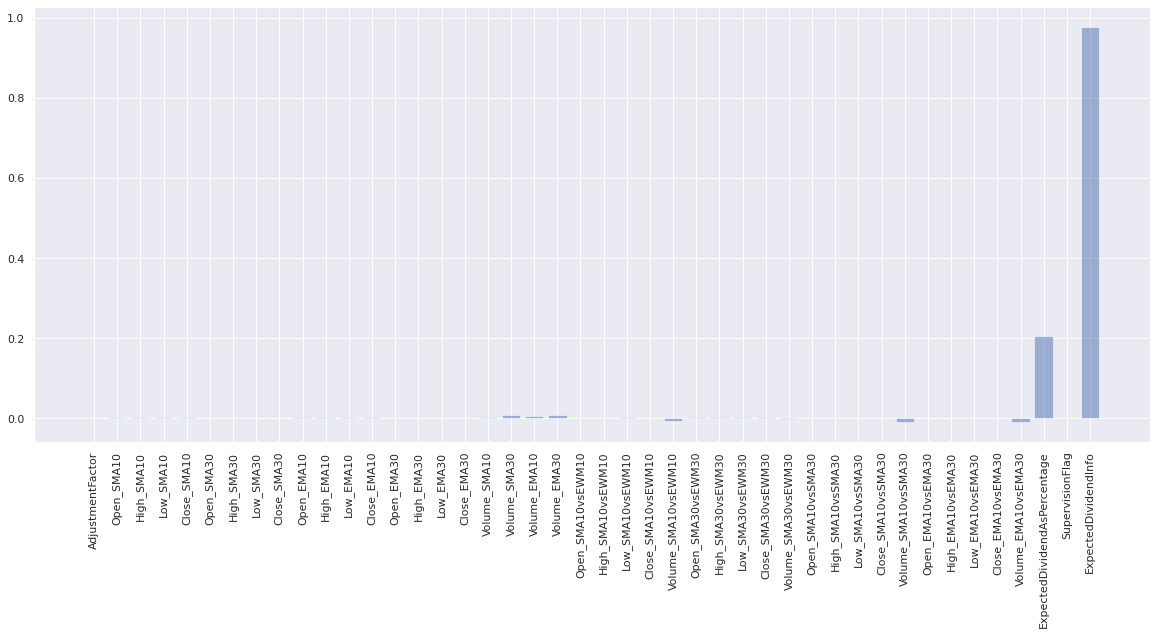

In [170]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(test_data.columns, pca.components_[1, :], label='Pattern 1', alpha=0.5)

Pattern 1: Looks like Divident is really important information!

<BarContainer object of 44 artists>

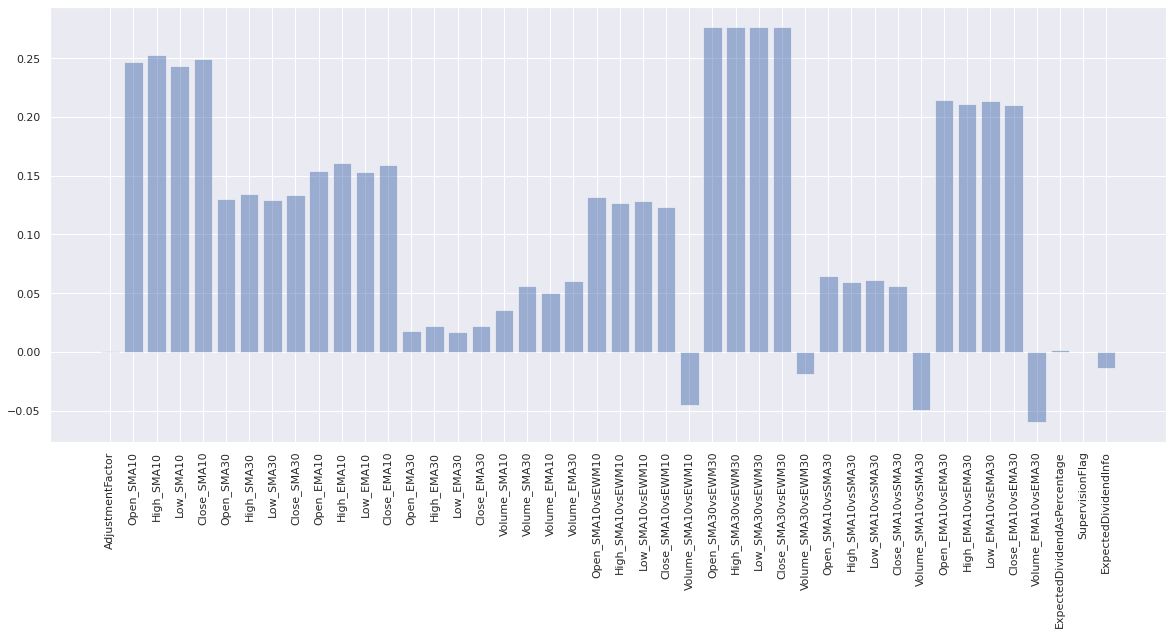

In [171]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(test_data.columns, pca.components_[2, :], label='Pattern 2', alpha=0.5)

Pattern 2: This one is much harder to decribe. It shows difference for pattern 0 (OHLC). 

<BarContainer object of 44 artists>

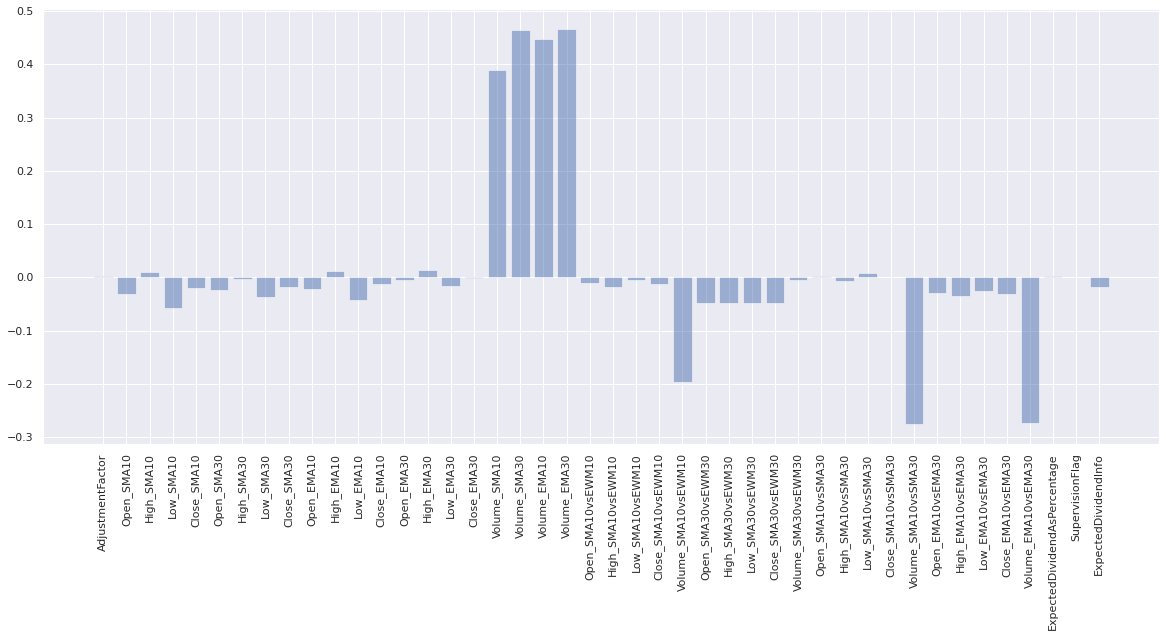

In [172]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(test_data.columns, pca.components_[3, :], label='Pattern 3', alpha=0.5)

Pattern 3: All volume features are correlated with each other - both based on SMA and EMA. There is a negative correlation with features representing ratio between small and big SMA, and small and big EMA. 

<BarContainer object of 44 artists>

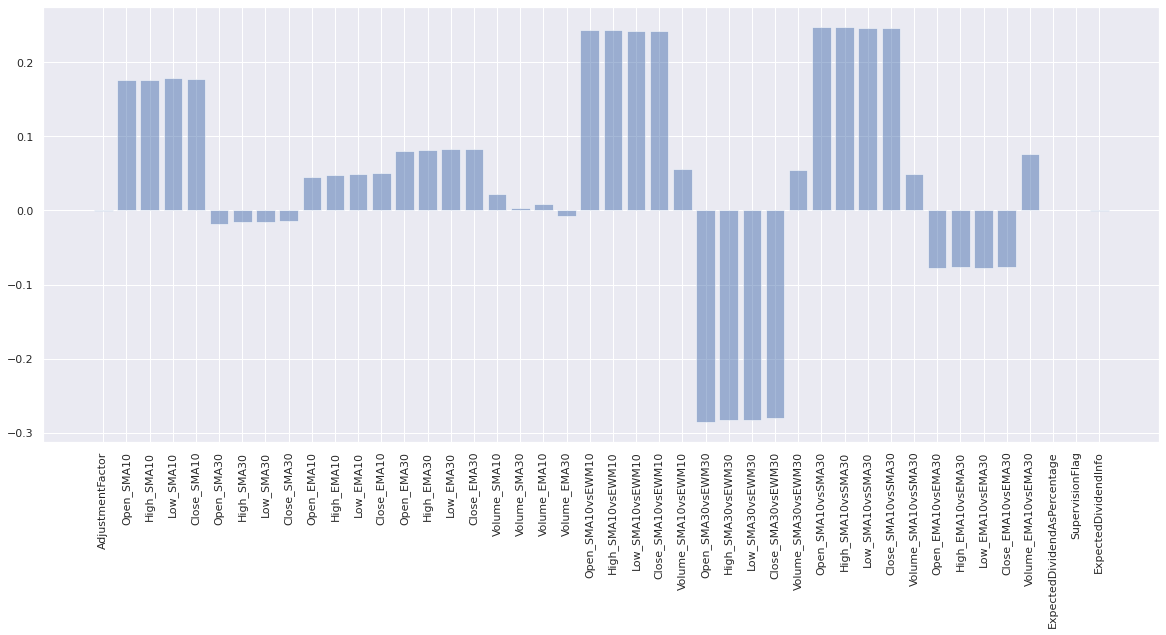

In [173]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation='vertical')
plt.bar(test_data.columns, pca.components_[4, :], label='Pattern 4', alpha=0.5)

Pattern 4: Last one is describing difference in OHLC as well.

In [174]:
# I will take first five patterns into cosideration 
test_data = pca.transform(test_data)[:, :5]
pd.DataFrame(test_data) 
# i will create a wrapper for PCA

,0,1,2,3,4
0,0.827601,-0.150724,0.913725,1.747648,0.151965
1,0.929450,-0.160673,0.838003,0.960574,0.067571
2,0.842047,-0.163435,0.647839,0.865971,-0.125395
3,1.046819,-0.146267,0.835112,1.845481,-0.170784
4,1.283421,-0.143826,0.911679,1.824162,-0.246159
...,...,...,...,...,...
2264918,-5.127983,-0.193350,0.861176,0.049193,-0.155720
2264919,-5.905776,-0.188439,0.534004,0.686943,-0.389622
2264920,-5.778301,-0.187242,0.937115,0.342223,-0.150583
2264921,-5.700464,-0.175951,1.285611,0.746489,-0.049012


### 1.3 Even subsets


In [175]:
# merge X and y
test_data = pd.DataFrame(test_data).join(y_test_data)

In [176]:
# Let's check size of subsets 
test_data['Class'].value_counts()

0.0    1212418
1.0     544992
2.0     507513
Name: Class, dtype: int64

We need to upsample short and long subsets and downsample none susbset. 

In [177]:
df_none = test_data[test_data['Class'] == 0]
df_short = test_data[test_data['Class'] == 1]
df_long= test_data[test_data['Class'] == 2]


# Upsample
df_short_upsampled = resample(df_short, 
                              replace=True,
                              n_samples=73000,
                              random_state=42)

df_long_upsampled = resample(df_long, 
                             replace=True,
                             n_samples=70000,
                             random_state=42)
# Downsample
df_none_downsampled = resample(df_none, 
                               replace=False,
                               n_samples=85000,
                               random_state=42)
 
 
# Combine majority class with upsampled minority class
test_data = pd.concat([df_short_upsampled, 
                          df_long_upsampled, 
                          df_none_downsampled])

In [178]:
# now it's better.. 
test_data['Class'].value_counts()

0.0    85000
1.0    73000
2.0    70000
Name: Class, dtype: int64

## 2. Building a model

In [179]:
# y oddzielnie funkcji celu
y_test_data = test_data.pop(item='Class')

In [182]:
# podział na test / train
X_train, X_test, y_train, y_test = train_test_split(test_data, y_test_data,
                                                    test_size=0.20,
                                                    stratify=y_test_data,
                                                    random_state=42
                                                    )

In [184]:
model = LogisticRegression(max_iter=100000)
model.fit(X_train, y_train)

print(classification_report(model.predict(X_test), y_test))
accuracy_score(model.predict(X_test), y_test)

              precision    recall  f1-score   support

         0.0       0.88      0.39      0.54     38414
         1.0       0.14      0.35      0.20      5950
         2.0       0.04      0.43      0.07      1236

    accuracy                           0.39     45600
   macro avg       0.35      0.39      0.27     45600
weighted avg       0.76      0.39      0.48     45600



0.3862061403508772

In [186]:
import xgboost as xgb
model = xgb.XGBClassifier(tree_method='gpu_hist')

model.fit(X_train, y_train)

accuracy_score(model.predict(X_test), y_test)
print(classification_report(model.predict(X_test), y_test))


              precision    recall  f1-score   support

         0.0       0.76      0.44      0.56     29638
         1.0       0.25      0.39      0.30      9296
         2.0       0.19      0.40      0.26      6666

    accuracy                           0.42     45600
   macro avg       0.40      0.41      0.37     45600
weighted avg       0.58      0.42      0.46     45600



In [ ]:
# grid 
parameters = {'criterion':['gini', 'entropy'],
              'splitter':['best', 'random'],
              'max_depth':[ 2, 3, 4, 5, 10, 50, 100, 200, 300, 400], 
              'min_samples_leaf':[2, 3, 4, 5, 6, 7, 8, 9], 
              'min_samples_split':[2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12]}

searcher = GridSearchCV(DecisionTreeClassifier(), parameters)
searcher.fit(pca_data, y_train)

# Report the best parameters and the corresponding score
print("Best LR params", searcher.best_params_)
print("Best LR accuracy", searcher.best_score_)

# Report the test accuracy using these best parameters
print("Test accuracy of best grid search hypers:", 
      searcher.score(pca_data, y_test))

bclf1 = BaggingClassifier(base_estimator = DecisionTreeClassifier(**searcher.best_params_), 
                         n_estimators = 100)

bclf1.fit(pca_data, y_train)
y_b1 = bclf1.predict(pca_test)

model = DecisionTreeClassifier()
model.fit(pca_data, y_train)
accuracy_score(model.predict(pca_test), y_test)

print(classification_report(model.predict(pca_test), y_test))



# Wnioski: 
# - słabo słabo.. trzeba dodać feature'ów bo za mało te dane tłumaczą sytuację
# - gridsearch (dla którego modelu? all ? )
# - zabawa tresholdem

## 2. Tranformers
Creating tranformers for preprocessing and modeling pipelines.


### 2.1 DataResampler

In [ ]:
class DataResampler(BaseEstimator, TransformerMixin):
    """
    Transformer resampling data (under- or oversampler)

    :param with_mean: using mean, set False when mean is close to zero
    :param with_std: using standard deviation, set False when it's close to 1
    """
    resample_level: list
    class_col: str

    def __init__(self, resample_level: list, class_col: str = 'Class'):
        self.resample_level = resample_level
        self.class_col = class_col


    def fit(self, X: pandas.DataFrame, y=None):
        """
        Calculating means and stds.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """

        for df_part in self.resample_level:


    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """

from sklearn.utils import resample

df_none = X_train[X_train['Class'] == 0]
df_short = X_train[X_train['Class'] == 1]
df_long= X_train[X_train['Class'] == 2]


# Upsample
df_short_upsampled = resample(df_short, 
                              replace=True,
                              n_samples=60000,
                              random_state=42)

df_long_upsampled = resample(df_long, 
                             replace=True,
                             n_samples=56000,
                             random_state=42)
# Downsample
df_none_downsampled = resample(df_none, 
                               replace=False,
                               n_samples=80000,
                               random_state=42)
 
 
# Combine majority class with upsampled minority class
df_resampled = pd.concat([df_short_upsampled, 
                          df_long_upsampled, 
                          df_none_downsampled])


        X_out = X.copy()  # robię kopię tej ramki
        if self.with_mean:
            X_out -= self.means
        if self.with_std:
            X_out /= self.stds
        return X_out

In [ ]:
# testing.. 

### 2.2 ColumnSelectorByType

In [ ]:
class ColumnsSelectorByType(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns of specified types.

    :param column_type: List of types of columns to select.
    """
    column_type: list

    def __init__(self, column_type: list):
        self.column_type = column_type

    def fit(self, X=None, y=None):
        """
        Doing nothing.

        :param X: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Selecting column of specified types.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added column.
        """
        return X.select_dtypes(include=self.column_type)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2324923 entries, 0 to 2324922
Data columns (total 23 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Open                          float64
 1   High                          float64
 2   Low                           float64
 3   Close                         float64
 4   Volume                        int64  
 5   AdjustmentFactor              float64
 6   ExpectedDividend              float64
 7   SupervisionFlag               bool   
 8   Class                         object 
 9   ExpectedDividendInfo          bool   
 10  ExpectedDividendAsPercentage  float64
 11  Close_SMA30_Value             float64
 12  Close_SMA30                   float64
 13  Close_SMA10_Value             float64
 14  Close_SMA10                   float64
 15  Close_EMA30_Value             float64
 16  Close_EMA30                   float64
 17  Volume_SMA30_Value            float64
 18  Volume_SMA30          

### 2.3 MyStandardScaler

In [ ]:
class MyStandardScaler(BaseEstimator, TransformerMixin):
    """
    Transformer which is scaling data

    :param with_mean: using mean, set False when mean is close to zero
    :param with_std: using standard deviation, set False when it's close to 1
    """
    with_mean: bool
    with_std: bool
    stds: pandas.Series
    means: pandas.Series

    def __init__(self, with_mean: bool = True, with_std: bool = True):

        self.with_mean = with_mean
        self.with_std = with_std
        self.stds = pd.Series(None, dtype='float64')
        self.means = pd.Series(None, dtype='float64')

    def fit(self, X: pandas.DataFrame, y=None):
        """
        Calculating means and stds.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Fitted transformer.
        """
        if self.with_mean:
            self.means = X.mean(axis=0)
        if self.with_std:
            self.stds = X.std(axis=0)
        return self

    def transform(self, X: pandas.DataFrame, y=None) -> pandas.DataFrame:
        """
        Adding column or columns.

        :param X: Dataset to work on
        :param y: Ignored. This parameter exists only for compatibility with :class:`~sklearn.pipeline.Pipeline`.
        :return: Input with added columns.
        """
        X_out = X.copy()  # robię kopię tej ramki
        if self.with_mean:
            X_out -= self.means
        if self.with_std:
            X_out /= self.stds
        return X_out

In [ ]:
# testing .. 

## 2. Pipeline
Preprocessing pipeline

In [ ]:
# preprocessing pipeline
data_preprocessing_pipeline = Pipeline(steps=[
    # std
    ('resample_dataset')
    ('standarize_data', MyStandardScaler()),
    
])

In [ ]:
# fit & tranform - do połączenia w jeden pipe ale jak dodam jeszcze

X_data = data_preparation_pipeline.fit_transform(X=data)



## 3. Processing data and modeling

0          0
1          0
2          0
3          2
4          0
          ..
2264918    1
2264919    0
2264920    2
2264921    0
2264922    0
Name: Class, Length: 2264923, dtype: category
Categories (3, int64): [0, 1, 2]

0    1212418
1     544992
2     507513
Name: Class, dtype: int64